# 动力学性质计算与检验——以计算体系扩散性质为例

对化学体系来说，体系的性质通常可以分为热力学性质与动力学性质，其中热力学性质包括密度、蒸发焓、RDF（radial distribution function, 径向分布函数）以及压缩系数等等；动力学性质则包含MSD（Mean Square Displacement, 均方位移）、扩散系数、电导率以及介电常数等。动力学性质对复杂化学体系如电解液的研究有着重要意义，其中扩散性质、导电性质更是在工业中有着举足轻重的地位。而利用分子动力学模拟的手段预测体系动力学性质，则对于实验以及工业生产有着指导意义。

在笔者的科研项目DMFF中，已经实现针对热力学性质优化力场参数，我们也得到了针对某一性质拟合表现更好的力场。然而，这样拟合出来的力场是否存在“过拟合”，以及可迁移性仍然在很大程度上存疑，因此仍然需要检验。同样的，动力学性质此时便成为了一种检验标准：我们可以对比优化前后力场在动力学性质方面的拟合表现，来判断优化后的力场的可迁移性。

以上，我们深刻理解了模拟动力学性质的重要性。这里笔者给出使用OpenMM进行经典分子动力学模拟、拟合体系动力学性质的工作流，拟合对象选取“最简单”的“复杂”化学体系之一：电解液体系。在接下来的案例中，我们会给出针对工业上常用的简单电解液体系（$LiPF_{6} /DMC/EC$）使用经典力场拟合扩散性质的方法，同时也与实验结果及我们使用DMFF优化过后力场的对比，供读者参考。

## 载入依赖

In [1]:
from openmm.app import *
from openmm import *
from openmm.unit import *
import random
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt

In [2]:
!git clone https://github.com/VINFeng/MSDcalculator.git

fatal: destination path 'MSDcalculator' already exists and is not an empty directory.


进入工作文件夹

In [1]:
import os
os.chdir(os.path.join("MSDcalculator"))

## 采样函数实现并获得模拟轨迹

我们有必要提两个问题：一个是计算体系扩散性质的方法，这个需要针对模拟轨迹分析得到，另一个则是采样函数的实现与模拟轨迹的获取。我们先给出对模拟的要求与轨迹获取的采样函数实现。

在计算动力学性质时，我们通常需要进行**NVE**模拟，即微正则系综采样，而非**NVT/NPT**模拟。这是因为为恒温性与恒压性都可能会干扰体系的动力学特性，从而导致动力学性质预测产生偏差。因此，为预测体系在多温度梯度下的动力学特性，可以先对体系进行多段**NVT**模拟，并取平衡后的部分轨迹抽样进行**NVE**模拟，进而分析**NVE**轨迹得到体系动力学性质。这里推荐阅读Maginn E J等著 *Best practices for computing transport properties* 里面会有更详细的介绍。

在我们的体系中，给定温度下进行**NVT**模拟使其平衡，步长为1fs，每10000步即10ps记录一次，总模拟时长为2ns；取**NVT**轨迹后半段即1ns~2ns部分作为预平衡结构，抽取其中10帧结构进行**NVE**模拟，分析体系动力学特性并进行平均，同时减小误差。分子动力学模拟轨迹的各项操作可以通过 MDtraj 完成。

同时值得提醒的是，在NVE模拟中，不能再使用Langevin模拟器，而需要使用Verlet模拟器。

### NVT预平衡

In [4]:
pdb = PDBFile('box.pdb')
forcefield = ForceField('ff.xml')
system = forcefield.createSystem(pdb.topology, nonbondedMethod=PME,
        nonbondedCutoff=1*nanometer, constraints=HBonds)
integrator = LangevinMiddleIntegrator(298*kelvin, 1/picosecond, 0.001*picoseconds)
platform = Platform.getPlatformByName('CUDA')
simulation = Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)
simulation.minimizeEnergy()
simulation.reporters.append(DCDReporter('nvt.dcd', 10000))
simulation.reporters.append(StateDataReporter(sys.stdout, 10000, step=True, potentialEnergy=True, temperature=True))
simulation.step(2000000)

将**NVT**轨迹分为两段，并抽取后半段作为预平衡结构

In [4]:
tr = md.load('nvt.dcd', top='box.pdb')
n_frames = tr.n_frames
n_segments = 2
segment_size = n_frames // n_segments

# 保存每个子轨迹
for i in range(n_segments):
    start_frame = i * segment_size
    end_frame = (i + 1) * segment_size
    segment = tr[start_frame:end_frame]
    segment.save(f'segment_{i+1}.dcd')

### 抽帧进行NVE模拟
从预平衡结构中，抽取十帧进行**NVE**模拟，并保存轨迹，以分析体系动力学特性

In [5]:
traj = md.load(f'segment_{2}.dcd', top='box.pdb')
positions = traj.xyz
KB = 1.380649e-23
NA = 6.0221408e23
m = 6.941 # Li atoms
T = 298 # temperature
kT = KB * T * NA 
sigma = np.sqrt(kT/m * 1e3) / 1e3
nout = 1000
dt = 0.001
nsteps = 1000000

vel0 = np.random.normal(loc=0.0, scale=sigma, size=np.shape(positions))
def tcf_v(vel0, vel1):
    return np.average(np.sum(vel0 * vel1, axis=1))

for i in range(10):
    integrator = VerletIntegrator(dt * picosecond)
    simulation = Simulation(pdb.topology, system, integrator, platform)
    simulation.context.setPositions(positions[i]*nanometer)
    simulation.context.setVelocitiesToTemperature(T*kelvin)
    def state_fun(pos, vel):
        pos = np.array(pos)
        vel = np.array(vel)
        return tcf_v(vel0[i], vel)*nout*dt
    simulation.reporters.append(StateDataReporter(sys.stdout, nout, time=True, temperature=True))
    dcd_reporter = DCDReporter('nve_traj_%s.dcd' % i, nout)
    simulation.reporters.append(dcd_reporter)
    simulation.step(nsteps)
    simulation.reporters.pop()

#"Time (ps)","Temperature (K)"
1.0000000000000007,299.04368288894096
1.9999999999998905,299.8307891978385
2.9999999999997806,294.34727726337934
3.9999999999996705,297.4966894460328
5.000000000000004,297.4827503267245
6.000000000000338,297.7695149588263
7.000000000000672,295.8510863082709
8.000000000001005,297.69774617134715
9.000000000000451,295.5843454136455
9.999999999999897,294.40856113931136
10.999999999999343,295.95963630225043
11.999999999998789,296.6634969793643
12.999999999998234,293.1373008715396
13.99999999999768,298.16964610076116
14.999999999997126,296.62497085407324
15.999999999996572,296.3738349058473
16.999999999997794,298.48465103085454
17.999999999999016,300.647697859402
19.000000000000238,298.7418766820137
20.00000000000146,296.1322663237551
21.000000000002682,295.22868715373863
22.000000000003904,295.86282200269545
23.000000000005127,299.2601132093085
24.00000000000635,296.0815319494664
25.00000000000757,297.0151452349816
26.000000000008793,294.75589522054787
27.0000

## 扩散性质的计算

在计算扩散性质之前，我们有必要讲一讲计算方法：我们可以通过均方位移（MSD）计算扩散系数，因为它们之间存在直接的数学关系。扩散系数是一个衡量粒子在物质中传播的速度的物理量，它与粒子的均方位移（MSD）相关。

在扩散过程中，粒子的运动符合随机游走或布朗运动模型。对于三维随机游走，粒子在每个方向上的位移是独立的，我们可以将总的均方位移表示为三个方向的位移平方和的平均值：

$$
\operatorname{MSD}(t)=\left\langle\left|\Delta r_i(t)\right|^2\right\rangle=\frac{1}{N}\left\langle\sum_i\left|r_i(t)-r_i(0)\right|^2\right\rangle
$$

根据爱因斯坦关系（Einstein Relation）和菲克定律（Fick's Law），我们可以得到扩散系数（D）和均方位移之间的关系：

$$
D=\frac{1}{6} \lim _{t \rightarrow \infty} \frac{\mathrm{d}(\text { MSD })}{\mathrm{d} t}
$$

在这个公式中，$t$ 是时间，$D$ 是扩散系数。公式表明，MSD 随时间线性增长，其斜率与扩散系数成正比。因此，我们可以通过对 MSD 数据进行线性拟合，计算出 MSD 与时间的线性关系，从而获得扩散系数。

需要注意的是，这种方法基于扩散过程中粒子的运动是随机的、无记忆的假设。在某些情况下，这种假设可能不成立，比如在有长程相互作用或有序晶格中的粒子运动。在这种情况下，我们需要采用其他方法来计算扩散系数。然而，在许多实际应用中，尤其是液体和气体中的粒子扩散，使用 MSD 计算扩散系数是一种非常有效的方法。

回到我们的体系：得到10段NVE轨迹后，我们对每一段轨迹都分别求锂离子MSD，并最后做平均处理，减小误差：

In [6]:
# Define the number of trajectories you want to process
num_trajectories = 10  # You can change this number to match your needs

for traj_index in range(num_trajectories):
    # Load the trajectory for the current index
    traj_filename = f'nve_traj_{traj_index}.dcd'
    top_filename = 'box.pdb'
    nve_traj = md.load(traj_filename, top=top_filename)

    # Get the ion indices
    ion_indices = nve_traj.top.select('name L07')

    # Define an empty list to store MSD for each trajectory
    msd_all = []

    # Loop through all time steps and calculate MSD
    for i in range(nve_traj.n_frames - 1):
        pos0 = nve_traj.xyz[0, ion_indices, :]
        pos1 = nve_traj.xyz[i, ion_indices, :]
        box = nve_traj.unitcell_vectors[i]
        dpos = pos1 - pos0
        box_inv = np.linalg.inv(box)
        ds = np.dot(dpos, box_inv)
        ds -= np.around(ds)
        dr = np.dot(ds, box)
        msd_value = np.average(np.sum(dr ** 2, axis=1))
        msd_all.append(msd_value)

    # Convert the list to a NumPy array
    msd_all = np.array(msd_all)

    # Define the time variable (you should set this according to your data)
    time = nve_traj.time[1:]

    # Save MSD data to a text file with a unique name for each trajectory
    output_filename = f'msd_data{traj_index}.txt'
    np.savetxt(output_filename, np.column_stack((time, msd_all)), header='Time (ps)\tMSD (nm^2)', fmt='%1.6f\t%1.6f')

对于上面的代码，其中的一处我们给出一点额外说明：
```python
ds = np.dot(dpos, box_inv)
ds -= np.around(ds)
dr = np.dot(ds, box)
```
可能有同学会疑惑这几行代码的作用：在模拟过程中，体系模拟轨迹里可能存在粒子跨越周期性边界（也就是我们常说的“**盒子**”）的情况。因此，我们需要先对粒子的位移向量进行预处理，排除边界问题。通过将位移向量**dpos**与盒子的逆矩阵**box_inv**相乘，将位移向量从盒子坐标系转换为实际坐标系上的**ds**。然后，通过减去位移向量四舍五入后的整数**np.around(ds)** 将位移向量重新调整到盒子的周期性边界内，以便正确计算均方位移。

对十段轨迹的MSD做平均处理：

In [7]:
# Define an empty list, used to store all the MSD data
MSD_all = []

# Define an empty list, used to store time values (assuming they are the same for all files)
time_values = []

# Loop through all files, load data, and append it to the lists
for i in range(10):
    filename = f'msd_data{i}.txt'
    data = np.loadtxt(filename, skiprows=1)
    MSD_all.append(data[:, 1])
    
    # Assuming time values are the same for all files, only store them once
    if i == 0:
        time_values = data[:, 0]

# Convert the list of MSD arrays to a 2D NumPy array
MSD_all = np.array(MSD_all)

# Calculate the mean of the MSD values along axis 0 (across all trajectories)
MSD_mean = np.mean(MSD_all, axis=0)

# Save the mean MSD data as a new text file
np.savetxt('MSD_data.txt', np.column_stack((time_values, MSD_mean)), header='Time (ps)\tMSD (nm^2)', fmt='%1.6f\t%1.6f')

给出锂离子的MSD图像：

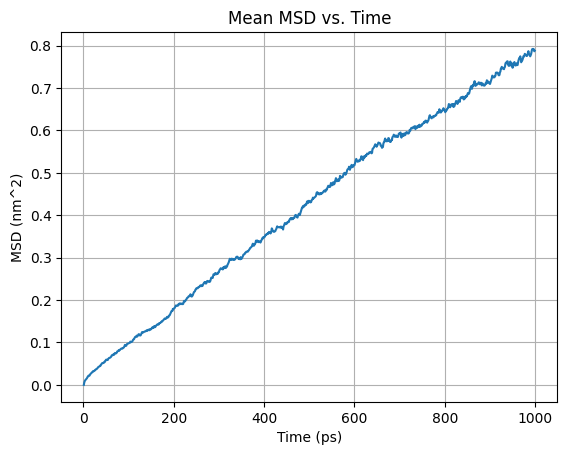

In [8]:
# Load the data from 'MSD_data.txt'
data = np.loadtxt('MSD_data.txt', skiprows=1)
time = data[:, 0]
MSD_mean = data[:, 1]

# Create a plot
plt.plot(time, MSD_mean)
plt.xlabel('Time (ps)')
plt.ylabel('MSD (nm^2)')
plt.title('Mean MSD vs. Time')
plt.grid(True)

# Show the plot
plt.show()

依据上面的公式，可以计算锂离子的扩散系数：

In [9]:
# 对MSD数据进行拟合，得到扩散系数
start_time = 0 # ps
end_time = 50  # ps
fit = np.polyfit(data[:, 0][start_time:end_time], data[:, 1][start_time:end_time], 1)
diff_coeff = fit[0] / 6.0 # 离子的扩散系数，单位为 m^2/s

print('Diffusion coefficient of Li+ =', diff_coeff, 'nm^2/ps')

Diffusion coefficient of Li+ = 0.00017084529011604643 nm^2/ps


由此，我们便完整体验了一遍扩散系数的计算方法。

## 拓展*

回到我们开头提到过目的：通过扩散系数的计算检验面向热力学性质优化过后的力场是否具有可迁移性。这里我们直接给出了面向密度优化过后的力场 *ffopt.xml* 依照同样的方式，我们可以得到其MSD与相应的扩散系数。MSD的数据我们记录在 **MSD_opt_data.txt** 中。对比二者有：

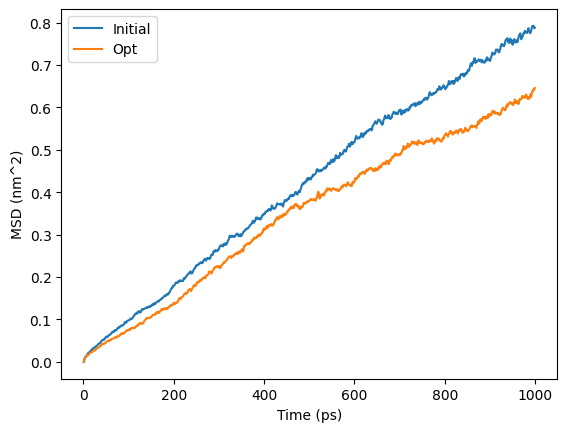

Diffusion coefficient of Li+ (Initial) = 0.0002295973684210527 nm^2/ps
Diffusion coefficient of Li+ (Opt) = 0.00017854210526315798 nm^2/ps


In [10]:
# Load data from 'MSD_data.txt' and 'MSD_opt_data.txt'
data_initial = np.loadtxt('MSD_data.txt', skiprows=1)
data_opt = np.loadtxt('MSD_opt_data.txt', skiprows=1)

# Extract time and MSD values
time_initial = data_initial[:, 0]
MSD_initial = data_initial[:, 1]
time_opt = data_opt[:, 0]
MSD_opt = data_opt[:, 1]

# Define time ranges for fitting
start_time = 0  # ps
end_time = 20   # ps

# Find the corresponding indices for the selected time range
start_index = np.where(time_initial >= start_time)[0][0]
end_index = np.where(time_initial <= end_time)[0][-1]

# Extract the time and MSD values within the selected time range for both datasets
time_range_initial = time_initial[start_index:end_index + 1]
MSD_range_initial = MSD_initial[start_index:end_index + 1]
time_range_opt = time_opt[start_index:end_index + 1]
MSD_range_opt = MSD_opt[start_index:end_index + 1]

# Perform linear fit to obtain the diffusion coefficients
fit_initial = np.polyfit(time_range_initial, MSD_range_initial, 1)
fit_opt = np.polyfit(time_range_opt, MSD_range_opt, 1)

diff_coeff_initial = fit_initial[0] / 6.0  # Diffusion coefficient for initial data in nm^2/ps
diff_coeff_opt = fit_opt[0] / 6.0        # Diffusion coefficient for optimized data in nm^2/ps

# Plot MSD data
plt.plot(time_initial, MSD_initial, label='Initial')
plt.plot(time_opt, MSD_opt, label='Opt')
plt.xlabel('Time (ps)')
plt.ylabel('MSD (nm^2)')
plt.legend()

# Show the plot
plt.show()

# Print diffusion coefficients
print('Diffusion coefficient of Li+ (Initial) =', diff_coeff_initial, 'nm^2/ps')
print('Diffusion coefficient of Li+ (Opt) =', diff_coeff_opt, 'nm^2/ps')

优化力场前多温度梯度下的MSD：

![s](https://i.postimg.cc/Z55GwRjm/MSDOPLS.png)

优化力场后多温度梯度下的MSD：

![s](https://i.postimg.cc/Kj76H3dG/MSD.jpg)

优化前后扩散系数及实验值对比：

![s](https://i.postimg.cc/0QKxcQkj/image.jpg)

从对比可以看出，面向热力学性质优化过后的力场，在动力学性质方面的表现也变得更好了。我们有理由相信，优化过后的力场参数对体系整体来说都是更“合理的”，这为可迁移性的验证增添了说服力。